# BT4222 Final Project

## COVID-19 Fake News Classifier

Group 13

## Importing Packages

In [72]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score, recall_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
import gensim

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ensemble
import xgboost
from sklearn.ensemble import RandomForestClassifier

# Probabilistic 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Online
from sklearn.linear_model import PassiveAggressiveClassifier


# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import gc
from datetime import datetime


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Settings

In [2]:
# SETTINGS
GOOGLE_COLAB = False # If using Google Colab, set to true, else false.
RANDOM_STATE = 42

# DATASET
TRAIN_SIZE = 0.8

#SETTINGS
RANDOM_STATE = 42

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# TENSORFLOW
SEQUENCE_LENGTH = 300
BATCH_SIZE = 128

gc.collect()

0

## Loading Datasets

In [3]:
train_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Train.csv")
val_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Val.csv")
df = pd.concat([train_ds,val_ds]).reset_index()

In [4]:
df.head()

,index,id,tweet,label
0,0,1,The CDC currently reports 99031 deaths. In gen...,real
1,1,2,States reported 1121 deaths a small rise from ...,real
2,2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,4,5,Populous states can generate large case counts...,real


In [5]:
df.label.unique()

array(['real', 'fake'], dtype=object)

In [6]:
df = df.drop('id', axis=1)

## Sanity Check




In this section, we check for:
1.   Null inputs
2.   Duplicated rows

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   8560 non-null   int64 
 1   tweet   8560 non-null   object
 2   label   8560 non-null   object
dtypes: int64(1), object(2)
memory usage: 200.8+ KB


In [8]:
df.duplicated().sum()

0

In [9]:
df.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

<AxesSubplot:>

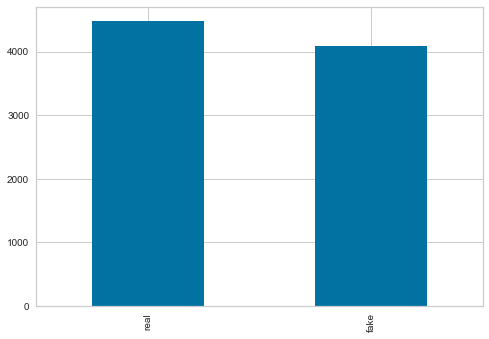

In [10]:
df.label.value_counts().plot(kind='bar')

## Data Pre-processing

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()

In [12]:
", ".join(stop_words)


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

### Previewing Tweets

In [13]:
print(df.tweet.sample(15).values)

['In Lagos we are working with @LSMOH @WHO and other partners in the operationalisation of sample collection sites in Local Governments for #COVID19 diagnosis This is part of our strategy to ensure cases are detected early #TakeResponsibility https://t.co/17vk5mE1Dg'
 'Note: The 15 deaths reported for Lagos State on 23rd July include previously unreported deaths. A breakdown of cases by state can be found via https://t.co/zQrpNeOfet #TakeResponsibility https://t.co/O9QsvFjRP5'
 "Taking a bath with extremely hot water will prevent coronavirus! This 'False' claim is a perfect example of how fatal fake news can be. Use #MainBhiNewschecker and tell us some of the most fatal 'False' claims that you came across and debunked. https://t.co/PoUvxPuis3"
 'For months, the Trump Administration was repeatedly warned about the threat COVID-19 posed to our nation. They ignored the experts, failed to take action, and now Americans are paying the price. https://t.co/YiSTQPnLNy'
 '91 new cases of #COVID

### Creating a column for word count

In [14]:
df['length'] = df['tweet'].apply(lambda x: len(x.split()))

### Preliminary Length Analysis

In [15]:
df['length'].describe()

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
max      1456.00000
Name: length, dtype: float64

<AxesSubplot:>

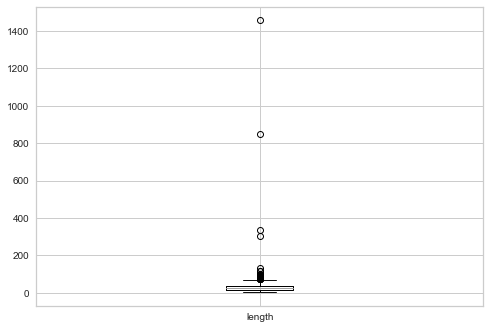

In [16]:
df.boxplot(column=['length'])

We notice outliers with extreme number of words. Previewing outlier articles here.

In [17]:
df[df['length']>150]

,index,tweet,label,length
270,270,"Amoxi"" Capsule made in US is the only medicine...",fake,1456
1109,1109,"Actors"" applauded Macron when he visited the s...",fake,847
6306,6306,Man visited Albany N.Y. days before dying from...,fake,336
8153,1733,I'm so happy that we’re able to do something v...,real,304


In [18]:
for tweet in df['tweet'][df['length']>150].values:
  print(tweet)

Amoxi" Capsule made in US is the only medicine that can completely cure COVID-19.
Egyptian Health Minister arrive in Italy with secret coronavirus cure.
 Dr Charles Lieber a Harvard professor has been arrested in the USA for manufacturing the coronavirus and selling it to China. A video news report from WCVB a TV station in Boston Massachusetts is shared with the Facebook post.
Mountain Matterhorn in Switzerland was lit in three colours of Indian flag as a token of gratitude to India for sending Hydroxychloroquine.
Al-Azhar Imam said he is considering exceptions on Ramadan fasting as the research says that the mouth must be kept wet to prevent COVID-19
 Japanese Nobel Tasuku Honjo says coronavirus was created in the Wuhan laboratory
A man collapses in 5 minutes after showing COVID-19 symptoms in India.
Celebrities spreading misinformation about coronavirus and the Janata curfew in India.
 Multiple posts shared repeatedly on Facebook and Twitter since March 2020 claim that Israel has re

We will remove the outlier articles to reduce noise when building our models.

In [19]:
df = df[df['length'] < 150]

(0.0, 200.0)

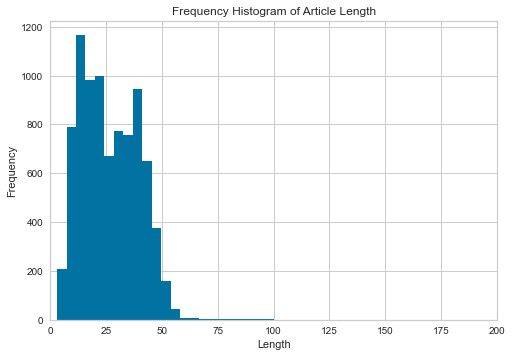

In [20]:
plt.hist(df['length'],bins=30)
plt.gca().set(title='Frequency Histogram of Article Length', ylabel='Frequency', xlabel='Length')
plt.xlim(0,200)


### Text Cleaning

- Transform to lowercase
- Remove trailing white spaces
- Remove stopwords
- Stem and lemmatize words to root form

In [21]:
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmer.lemmatize(stemmer.stem(token)))
    return " ".join(tokens)

In [22]:
df.tweet = df.tweet.apply(lambda x:preprocess(x))

In [23]:
print(df.tweet.sample(15).values)

['today 87604 85 92 101951 total covid19 case discharg chennai tamilnadu covid 19 covid covid 19 covid 19 covid19india covidupd coronavirus coronaupd coronavirusindia coronavirusupd coronaviruspandem'
 'break donald trump say need read book coronavirus test proper understand number white hous reveal book particular'
 'daili updat publish track 16 1 million test 492k yesterday anoth time high worth note 7 day averag remain 400k low number earli week detail see'
 'american dutch mainstream news medium use photo young boy portrait pictur report three differ corona victim also use pictur 69 year old american corona victim twice articl work polic forc declar work univers therefor mainstream news medium tri mislead reader amount peopl actual die corona multipli'
 'bollywood actress aishwarya rai host coronavirus telethon auction mumbai india auction bollywood'
 'first test result moderna vaccin disappoint'
 'claim india began screen travel covid19 affect nation singl case pm modi fact 20 cou

## Exploratory Data Analysis

### Length Analysis

<AxesSubplot:title={'center':'length'}, xlabel='label'>

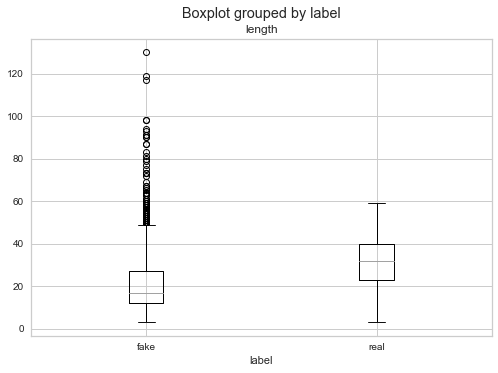

In [24]:
df.boxplot(column=["length"], by="label")

<AxesSubplot:xlabel='length', ylabel='Density'>

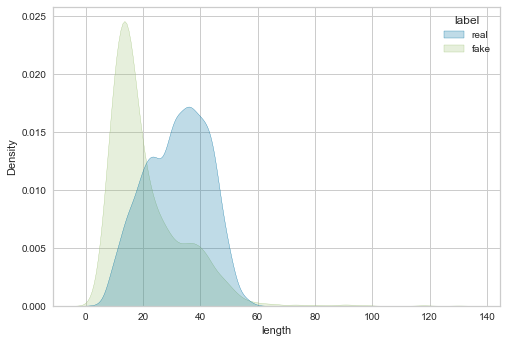

In [25]:
sns.kdeplot(data=df, x="length", hue="label", shade=True)

Fake news tends to be short than real news. 

### Word Clouds

#### Setting word exclusions from our wordclouds

In [26]:
cloud_stop = set(STOPWORDS)
cloud_stop.update(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19", "amp"])

In [27]:
def generate_wordcloud(text):
    wordcloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Word Cloud for ALL text

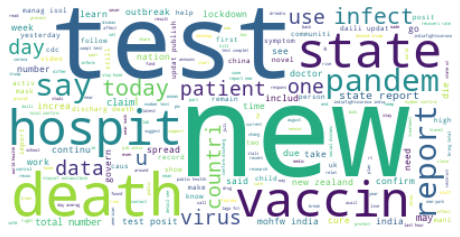

In [28]:
all_text = " ".join(tweet for tweet in df.tweet)
generate_wordcloud(all_text)

#### Word Cloud for Fake News

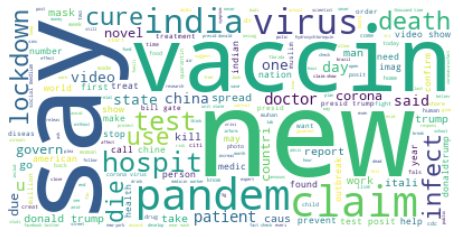

In [29]:
fake_text = " ".join(tweet for tweet in df[df['label']== 'fake'].tweet)
generate_wordcloud(fake_text)

#### Word Cloud for Real News

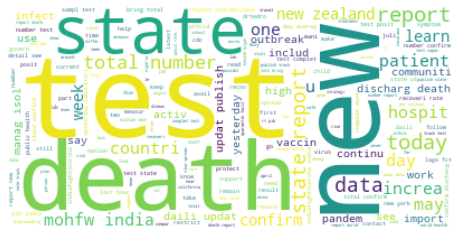

In [30]:
real_text = " ".join(tweet for tweet in df[df['label']== 'real'].tweet)
generate_wordcloud(real_text)

## Preparing Training and Testing Data

In [31]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)
print("TRAIN size: ", len(df_train))
print("TEST size: ", len(df_test))

TRAIN size:  6844
TEST size:  1712


### Label Encoding

In [32]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train  = encoder.transform(df_train.label.tolist())
y_test  = encoder.transform(df_test.label.tolist())

y_train  = y_train .reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [33]:
print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (6844, 1)
y_test (1712, 1)


## Text Vectorisation Methods

### Count Vectorisation

In [34]:
count_vectorizer = CountVectorizer()
x_train_countv = count_vectorizer.fit_transform(df_train.tweet).astype(np.float64)
x_test_countv = count_vectorizer.transform(df_test.tweet).astype(np.float64)

#### Previewing Vocabulary

In [35]:
pd.DataFrame(count_vectorizer.vocabulary_, index=[0]).T

,0
nasser,7401
ziberi,11036
test,10015
posit,8212
covid,3796
...,...
danielleiwood,3974
bleak,2863
bankofamerica,2638
mandetta,6870


### TF-IDF Vectorisation

#### Vectorising Text Using TF-IDF Vectorizer

In [36]:
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(df_train.tweet)
x_test_tfidf = tfidf_vectorizer.transform(df_test.tweet)

#### Previewing Sparse TF-IDF Vector

In [37]:
train_tfidf_sklearn = pd.DataFrame(x_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
train_tfidf_sklearn.sort_index().round(decimals=5)
train_tfidf_sklearn 

,00,000,006,00ice,00pm,01,011,0141,02,03,...,zoo,zoodirector,zookeep,zoolog,zoom,zoonot,zuckoff,zurich,zydus,zyphr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Previewing Words with Highest TFIDF Score

In [38]:
train_tfidf_sklearn = train_tfidf_sklearn.stack().reset_index()
train_tfidf_sklearn = train_tfidf_sklearn.rename(columns={0:'tfidf', 'level_0': 'id','level_1': 'term', 'level_2': 'term'})
train_tfidf_sklearn_sorted = train_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id'])


In [39]:
train_tfidf_sklearn_sorted.head(10)

,id,term,tfidf
7401,0,nasser,0.644215
11036,0,ziberi,0.644215
8212,0,posit,0.284045
10015,0,test,0.196617
488,0,19,0.164663
...,...,...,...
75656208,6843,00,0.000000
75656209,6843,000,0.000000
75656210,6843,006,0.000000
75656211,6843,00ice,0.000000


In [40]:
gc.collect()

0

### Word2Vec Model

#### Building Documents

In [41]:
documents = [tweet.split() for tweet in df_train.tweet]

#### Initialising word2vec model with hyperparameters

In [42]:
if GOOGLE_COLAB:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)
else:
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)


#### Building Vocab

In [43]:
w2v_model.build_vocab(documents)

#### Training word2vec model

In [44]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(2663217, 3787264)

In [45]:
w2v_model.wv.most_similar("covid")


[('coronaupd', 0.3597111105918884),
 ('covid19india', 0.34202221035957336),
 ('coronavirusindia', 0.3401907980442047),
 ('covidupd', 0.33739006519317627),
 ('link', 0.3210941255092621),
 ('acquir', 0.31270796060562134),
 ('coronaviruspandem', 0.30684322118759155),
 ('unknown', 0.29941990971565247),
 ('pneumonia', 0.2983008921146393),
 ('diagnos', 0.2904316782951355)]

#### Tokenise Text

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total unique words", vocab_size)

Total unique words 11088


#### Previewing top 20 words by Count

In [47]:
token_count = dict(tokenizer.word_counts)
token_count_df = pd.DataFrame(dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True)),index=["Count"]).T
token_count_df.head(20)

,Count
covid,2538
case,2176
19,2137
test,1810
coronavirus,1706
covid19,1584
new,1163
report,1099
state,1095
death,870


#### Converting text to sequence of integers

In [48]:
x_train_word2vec = tokenizer.texts_to_sequences(df_train.tweet)
x_test_word2vec = tokenizer.texts_to_sequences(df_test.tweet)

#### Padding

In [49]:
x_train_word2vec  = pad_sequences(x_train_word2vec , maxlen=SEQUENCE_LENGTH)
x_test_word2vec  = pad_sequences(x_test_word2vec , maxlen=SEQUENCE_LENGTH)

#### Embedding Matrix

Populating matrix with weights

In [50]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(11088, 300)


## Model Building

In [51]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

METRICS = ['accuracy', 'Precision','Recall','AUC']

CALLBACKS = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

EPOCHS = 12

results_store = {}

### Helper Functions

In [73]:
def batch_generator(x, y, batch_size):
    samples_per_epoch = x.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].toarray()
        y_batch = y[min(index_batch):max(index_batch)+1]
        counter += 1
        x_batch = np.expand_dims(x_batch, axis=2)
        yield x_batch, np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

def get_F1(precision, recall):
    if precision == recall == 0:
        return 0
    return 2* (precision*recall)/(precision+recall)

def get_results(history):
    loss = history[0]
    accuracy = history[1]
    precision = history[2]
    recall = history[3]
    auc = history[4]
    F1 = get_F1(precision,recall)
    results ={
        "Loss": loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "F1 Score": F1
    }
    return results

def get_evaluation_vect(model, x_test, model_name, vectoriser, duration):
    name = model_name + " " + vectoriser
    x_test_DL = np.expand_dims(x_test.toarray(), axis=2)
    eval = model.evaluate(x_test_DL, y_test, batch_size=32)
    result = get_results(eval)
    result["time"] = duration.total_seconds()
    result["model"] = model_name
    result["vectoriser"] = vectoriser
    results_store[name] = result
    return result

def get_deep_learning_results_vect(model, model_name):
    gc.collect()
    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
    
    #count_vectorizer
    print("\n >>> Training Count Vectorisation Model ========================================= \n")
    time_start = datetime.now()
    fit_countv = model.fit(
        batch_generator(x_train_countv, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_countv.shape[0]/32
    )
    duration = datetime.now() - time_start
    result_countv = get_evaluation_vect(model, x_test_countv, model_name, "count", duration)

    #tf-idf vectorizer
    print("\n >>> Training TFIDF Vectorisation Model ========================================= \n")
    time_start = datetime.now()
    fit_tfidf = model.fit(
        batch_generator(x_train_tfidf, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_tfidf.shape[0]/32      
    )
    duration = datetime.now() - time_start
    result_tfidf = get_evaluation_vect(model, x_test_tfidf, model_name, "tfidf", duration)

    
    return pd.DataFrame(results_store).T

def get_evaluation_w2v(model, model_name, vectoriser, duration):
    name = model_name + " " + vectoriser
    eval = model.evaluate(x_test_word2vec , y_test , batch_size=BATCH_SIZE)
    result = get_results(eval)
    result["time"] = duration.total_seconds()
    result["model"] = model_name
    result["vectoriser"] = vectoriser
    results_store[name] = result
    return result

def get_deep_learning_results_w2v(model, model_name):
    gc.collect()
    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
              
    print("\n >>> Training Word2Vec Model ========================================= \n")
    time_start = datetime.now()
    fit_word2vec = model.fit(
        x_train_word2vec , y_train ,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        verbose=1,
        callbacks=CALLBACKS
    )
    duration = datetime.now() - time_start
    result_word2vec = get_evaluation_w2v(model, model_name, "word2vec", duration)
    
    return pd.DataFrame(results_store).T

## Deep Learning Models

### TextCNN

In [53]:
cnn_vect_model = tf.keras.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(cnn_vect_model, "CNN")



 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 16s 68ms/step - loss: 0.6405 - accuracy: 0.6357 - precision: 0.6255 - recall: 0.7693 - auc: 0.6925
Epoch 2/12
213/213 [==============================] - 15s 71ms/step - loss: 0.6183 - accuracy: 0.6788 - precision: 0.7023 - recall: 0.6778 - auc: 0.7006
Epoch 3/12
213/213 [==============================] - 17s 80ms/step - loss: 0.6170 - accuracy: 0.6786 - precision: 0.7017 - recall: 0.6783 - auc: 0.7016
Epoch 4/12
213/213 [==============================] - 17s 77ms/step - loss: 0.6165 - accuracy: 0.6788 - precision: 0.7021 - recall: 0.6783 - auc: 0.7018
Epoch 5/12
213/213 [==============================] - 16s 76ms/step - loss: 0.6163 - accuracy: 0.6790 - precision: 0.7023 - recall: 0.6783 - auc: 0.7015
Epoch 6/12
213/213 [==============================] - 16s 74ms/step - loss: 0.6161 - accuracy: 0.6790 - precision: 0.7023 - recall: 0.6783 - auc: 0.70

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf


In [54]:
cnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers. Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(cnn_word2vec_model, "CNN")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 4s 62ms/step - loss: 0.3220 - accuracy: 0.8613 - precision: 0.8762 - recall: 0.8567 - auc: 0.9350 - val_loss: 0.2413 - val_accuracy: 0.8876 - val_precision: 0.8903 - val_recall: 0.9069 - val_auc: 0.9649
Epoch 2/12
49/49 [==============================] - 2s 48ms/step - loss: 0.1874 - accuracy: 0.9263 - precision: 0.9376 - recall: 0.9207 - auc: 0.9782 - val_loss: 0.2199 - val_accuracy: 0.9066 - val_precision: 0.9286 - val_recall: 0.8989 - val_auc: 0.9702
Epoch 3/12
49/49 [==============================] - 2s 47ms/step - loss: 0.1423 - accuracy: 0.9493 - precision: 0.9620 - recall: 0.9406 - auc: 0.9879 - val_loss: 0.2132 - val_accuracy: 0.9109 - val_precision: 0.9156 - val_recall: 0.9229 - val_auc: 0.9726
Epoch 4/12
49/49 [==============================] - 2s 48ms/step - loss: 0.1027 - accuracy: 0.9703 - precision: 0.9814 - recall: 0.9616 - auc: 0.9943 - val_loss:

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec


### LSTM (Unidirectional)

In [55]:
lstm_vect_model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstm_vect_model, "LSTM")



 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 108s 480ms/step - loss: 0.6829 - accuracy: 0.5843 - precision: 0.5993 - recall: 0.6367 - auc: 0.5814
Epoch 2/12
213/213 [==============================] - 85s 396ms/step - loss: 0.6855 - accuracy: 0.5506 - precision: 0.5449 - recall: 0.8913 - auc: 0.5766
Epoch 3/12
213/213 [==============================] - 88s 414ms/step - loss: 0.6614 - accuracy: 0.6277 - precision: 0.6281 - recall: 0.7194 - auc: 0.6795
Epoch 4/12
213/213 [==============================] - 81s 378ms/step - loss: 0.6345 - accuracy: 0.6733 - precision: 0.7018 - recall: 0.6606 - auc: 0.6930
Epoch 5/12
213/213 [==============================] - 80s 375ms/step - loss: 0.6268 - accuracy: 0.6612 - precision: 0.6731 - recall: 0.6938 - auc: 0.6970
Epoch 6/12
213/213 [==============================] - 82s 382ms/step - loss: 0.6382 - accuracy: 0.6739 - precision: 0.7022 - recall: 0.6617 - au

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf


In [56]:
lstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(64, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(lstm_word2vec_model, "LSTM")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 7s 79ms/step - loss: 0.3421 - accuracy: 0.8618 - precision: 0.8601 - recall: 0.8796 - auc: 0.9327 - val_loss: 0.2541 - val_accuracy: 0.8949 - val_precision: 0.9153 - val_recall: 0.8910 - val_auc: 0.9626
Epoch 2/12
49/49 [==============================] - 3s 58ms/step - loss: 0.2255 - accuracy: 0.9091 - precision: 0.9262 - recall: 0.8981 - auc: 0.9687 - val_loss: 0.2432 - val_accuracy: 0.8876 - val_precision: 0.8747 - val_recall: 0.9282 - val_auc: 0.9694
Epoch 3/12
49/49 [==============================] - 3s 60ms/step - loss: 0.1992 - accuracy: 0.9222 - precision: 0.9351 - recall: 0.9152 - auc: 0.9751 - val_loss: 0.2128 - val_accuracy: 0.9022 - val_precision: 0.9187 - val_recall: 0.9016 - val_auc: 0.9737
Epoch 4/12
49/49 [==============================] - 3s 59ms/step - loss: 0.1781 - accuracy: 0.9320 - precision: 0.9480 - recall: 0.9207 - auc: 0.9801 - val_loss:

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec


### LSTM (Bidirectional)

In [57]:
bilstm_vect_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, input_shape=(None,1))),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(bilstm_vect_model, "BiLSTM")



 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 184s 840ms/step - loss: 0.6575 - accuracy: 0.6071 - precision: 0.6080 - recall: 0.7160 - auc: 0.6550
Epoch 2/12
213/213 [==============================] - 173s 809ms/step - loss: 0.6248 - accuracy: 0.6623 - precision: 0.6759 - recall: 0.6900 - auc: 0.7014
Epoch 3/12
213/213 [==============================] - 169s 791ms/step - loss: 0.6227 - accuracy: 0.6654 - precision: 0.6758 - recall: 0.7013 - auc: 0.7018
Epoch 4/12
213/213 [==============================] - 180s 842ms/step - loss: 0.6192 - accuracy: 0.6657 - precision: 0.6758 - recall: 0.7024 - auc: 0.7114
Epoch 5/12
213/213 [==============================] - 165s 770ms/step - loss: 0.6180 - accuracy: 0.6672 - precision: 0.6791 - recall: 0.6983 - auc: 0.7113
Epoch 6/12
213/213 [==============================] - 181s 848ms/step - loss: 0.6276 - accuracy: 0.6572 - precision: 0.6818 - recall: 0.6553

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf


In [58]:
bilstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(bilstm_word2vec_model, "BiLSTM")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 14s 139ms/step - loss: 0.3186 - accuracy: 0.8664 - precision: 0.8755 - recall: 0.8687 - auc: 0.9388 - val_loss: 0.2315 - val_accuracy: 0.8964 - val_precision: 0.9067 - val_recall: 0.9043 - val_auc: 0.9682
Epoch 2/12
49/49 [==============================] - 6s 115ms/step - loss: 0.2113 - accuracy: 0.9177 - precision: 0.9329 - recall: 0.9084 - auc: 0.9722 - val_loss: 0.2103 - val_accuracy: 0.9095 - val_precision: 0.9176 - val_recall: 0.9176 - val_auc: 0.9735
Epoch 3/12
49/49 [==============================] - 6s 116ms/step - loss: 0.1832 - accuracy: 0.9282 - precision: 0.9397 - recall: 0.9223 - auc: 0.9793 - val_loss: 0.2003 - val_accuracy: 0.9153 - val_precision: 0.9344 - val_recall: 0.9096 - val_auc: 0.9765
Epoch 4/12
49/49 [==============================] - 6s 119ms/step - loss: 0.1656 - accuracy: 0.9359 - precision: 0.9484 - recall: 0.9282 - auc: 0.9828 - val_

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf
BiLSTM word2vec,0.197995,0.936332,0.93508,0.940435,0.98092,0.93775,BiLSTM,word2vec


### LSTM + CNN

In [71]:
lstmcnn_vect_model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(None,1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstmcnn_vect_model, "LSTM+CNN")


 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
 15/213 [=>............................] - ETA: 1:55 - loss: 0.6926 - accuracy: 0.5771 - precision: 0.6000 - recall: 0.4304 - auc: 0.5368

KeyboardInterrupt: 

In [ ]:
lstmcnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(64, return_sequences=True),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
            
get_deep_learning_results_w2v(lstmcnn_word2vec_model, "LSTM+CNN")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 9s 113ms/step - loss: 0.3130 - accuracy: 0.8672 - precision: 0.8602 - recall: 0.8916 - auc: 0.9402 - val_loss: 0.2440 - val_accuracy: 0.8891 - val_precision: 0.8989 - val_recall: 0.8989 - val_auc: 0.9627
Epoch 2/12
49/49 [==============================] - 5s 95ms/step - loss: 0.2002 - accuracy: 0.9190 - precision: 0.9356 - recall: 0.9080 - auc: 0.9743 - val_loss: 0.2056 - val_accuracy: 0.9139 - val_precision: 0.9391 - val_recall: 0.9016 - val_auc: 0.9738
Epoch 3/12
49/49 [==============================] - 5s 96ms/step - loss: 0.1789 - accuracy: 0.9247 - precision: 0.9402 - recall: 0.9146 - auc: 0.9798 - val_loss: 0.1976 - val_accuracy: 0.9124 - val_precision: 0.9293 - val_recall: 0.9096 - val_auc: 0.9757
Epoch 4/12
49/49 [==============================] - 5s 99ms/step - loss: 0.1465 - accuracy: 0.9428 - precision: 0.9580 - recall: 0.9319 - auc: 0.9863 - val_loss

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf
BiLSTM word2vec,0.197995,0.936332,0.93508,0.940435,0.98092,0.93775,BiLSTM,word2vec
LSTM+CNN count,0.693495,0.50993,0.50993,1.0,0.5,0.675435,LSTM+CNN,count


### BiDirectional LSTM + CNN

In [ ]:
bilstmcnn_vect_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, input_shape=(None,1))),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(bilstmcnn_vect_model, "BiLSTM+CNN")

In [ ]:
bilstmcnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
            
get_deep_learning_results_w2v(bilstmcnn_word2vec_model, "BiLSTM+CNN")

## Ensemble Models

### Helper Methods

In [76]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

training_data_array = [x_train_countv.toarray(), x_train_tfidf.toarray(), x_train_word2vec]
testing_data_array = [x_test_countv.toarray(), x_test_tfidf.toarray(), x_test_word2vec]

names = ["count", "tfidf", "word2vec"]

def get_model_results(model, model_name, toarray):
    
    gc.collect()
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        time_start = datetime.now()
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])

        time_start = datetime.now()
        model.fit(x_train_iter, y_train.ravel())
        duration = datetime.now() - time_start

        pred_prob = model.predict_proba(x_test_iter)
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred_prob[:,1])
        accuracy = accuracy_score(y_test, pred)
        #accuracy = model.score(x_test_iter, y_test)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred_prob[:,1])
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }
        results["time"] = duration.total_seconds()
        results["model"] = model_name
        results["vectoriser"] = names[i]
        results_store[name] = results
    return pd.DataFrame(results_store).T

def pac_get_model_results(model, model_name, toarray):
    gc.collect()
    
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])

        time_start = datetime.now()
        model.fit(x_train_iter, y_train.ravel())
        duration = datetime.now() - time_start
        
        
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred)
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }
        results["time"] = duration.total_seconds()
        results["model"] = model_name
        results["vectoriser"] = names[i]
        results_store[name] = results
    return pd.DataFrame(results_store).T

### XGBoost

In [ ]:
xgbmodel = xgboost.XGBClassifier(objective='binary:logistic',  n_estimators = 10000, booster = 'gbtree', learning_rate = '0.007', eval_metric = 'auc',use_label_encoder=False)
get_model_results(xgbmodel, "xgb", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf
BiLSTM word2vec,0.197995,0.936332,0.93508,0.940435,0.98092,0.93775,BiLSTM,word2vec
LSTM+CNN count,0.693495,0.50993,0.50993,1.0,0.5,0.675435,LSTM+CNN,count


### RandomForest

In [ ]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
get_model_results(rfc, "rfc", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf
BiLSTM word2vec,0.197995,0.936332,0.93508,0.940435,0.98092,0.93775,BiLSTM,word2vec
LSTM+CNN count,0.693495,0.50993,0.50993,1.0,0.5,0.675435,LSTM+CNN,count


## Probabilistic Model

### Gaussian Naive Bayes Classifier

In [ ]:
gnb = GaussianNB()
get_model_results(gnb, "gnb", toarray=True)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf
BiLSTM word2vec,0.197995,0.936332,0.93508,0.940435,0.98092,0.93775,BiLSTM,word2vec
LSTM+CNN count,0.693495,0.50993,0.50993,1.0,0.5,0.675435,LSTM+CNN,count


### Multinomial Niave Bayes

In [ ]:
mnb = MultinomialNB()
get_model_results(mnb, "mnb", toarray=True)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf
BiLSTM word2vec,0.197995,0.936332,0.93508,0.940435,0.98092,0.93775,BiLSTM,word2vec
LSTM+CNN count,0.693495,0.50993,0.50993,1.0,0.5,0.675435,LSTM+CNN,count


## Online Learning Model

### Passive Aggressive Classier

In [77]:
pac = PassiveAggressiveClassifier(max_iter = 1000, C = 1, early_stopping = True)
pac_get_model_results(pac, "PAC", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser,time
CNN count,0.594349,0.706776,0.723764,0.687285,0.738389,0.705053,CNN,count,NaN
CNN tfidf,0.656084,0.617991,0.603399,0.731959,0.659921,0.661491,CNN,tfidf,NaN
CNN word2vec,0.232033,0.921729,0.914703,0.933562,0.97409,0.924036,CNN,word2vec,NaN
LSTM count,0.601276,0.705023,0.72439,0.680412,0.731198,0.701713,LSTM,count,NaN
LSTM tfidf,0.705881,0.50993,0.50993,1.0,0.345265,0.675435,LSTM,tfidf,NaN
LSTM word2vec,0.208979,0.929907,0.918799,0.946163,0.97924,0.93228,LSTM,word2vec,NaN
BiLSTM count,0.590107,0.705607,0.708005,0.719359,0.760274,0.713636,BiLSTM,count,NaN
BiLSTM tfidf,0.690092,0.514019,0.512038,0.998855,0.629491,0.677019,BiLSTM,tfidf,NaN
BiLSTM word2vec,0.197995,0.936332,0.93508,0.940435,0.98092,0.93775,BiLSTM,word2vec,NaN
LSTM+CNN count,0.693495,0.50993,0.50993,1.0,0.5,0.675435,LSTM+CNN,count,NaN


In [ ]:
pd.DataFrame(results_store).T.to_csv('results_store.csv', index=False)